## Lora PTI fine tune on SageMaker notebook
* Lora can be leveraged to fine tune the whole model like native text2image fine tune does. But it is more efficient with less storage useage. Besides, there are 2 other ways to use Lora, DreamBooth for Lora and Lora PTI. You can learn more from [cloneofsimo's repo](https://github.com/cloneofsimo/lora) who is the frist one to use Lora to fine tune SD.
* Regarding this notebook, we use PTI for demonstration.

### Install dependencies

In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install git+https://github.com/cloneofsimo/lora.git

In [ ]:
!pip install accelerate
!pip install bitsandbytes==0.35.4
!pip install -U triton
!pip install https://github.com/terrificdm/xformers-wheels/releases/download/v1/xformers-0.0.17rc482-cp310-cp310-manylinux2014_x86_64.whl

### Initialize environment

In [3]:
# Due to SageMaker upgrade notebook kernel recently, you might encounter error like "ImportError: /lib64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found", use below scripts to avoid
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

In [4]:
MODEL_NAME="runwayml/stable-diffusion-v1-5"
INSTANCE_DIR="images/source"
OUTPUT_DIR="stable_diffusion_weights/lora_pti"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $INSTANCE_DIR $OUTPUT_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $INSTANCE_DIR

### Traing a modle for generating a person in cyberpunk style  

* Regarding training parameters refer [here](https://github.com/cloneofsimo/lora/discussions/121).
* Change "--use_template" to "object" or "None", if your training subject is person or object.
* Difference betweent "object" and "None" of "--use_template" depends on whether you have captions for training images.
* Recommand to tag your training images with captions for consistent and better outputs. 

In [10]:
!lora_pti \
   --pretrained_model_name_or_path=$MODEL_NAME  \
   --instance_data_dir=$INSTANCE_DIR \
   --output_dir=$OUTPUT_DIR \
   --train_text_encoder \
   --resolution=512 \
   --train_batch_size=1 \
   --gradient_accumulation_steps=2 \
   --scale_lr \
   --learning_rate_unet=1e-4 \
   --learning_rate_text=1e-5 \
   --learning_rate_ti=5e-4 \
   --color_jitter \
   --lr_scheduler="linear" \
   --lr_warmup_steps=0 \
   --placeholder_tokens="cypk" \
   --use_template="style" \
   --save_steps=100 \
   --max_train_steps_ti=500 \
   --max_train_steps_tuning=500 \
   --perform_inversion=True \
   --clip_ti_decay \
   --weight_decay_ti=0.000 \
   --weight_decay_lora=0.001\
   --continue_inversion \
   --continue_inversion_lr=1e-4 \
   --device="cuda:0" \
   --lora_rank=4 \
   --enable_xformers_memory_efficient_attention
   # --use_face_segmentation_condition \

PTI : Initializer Tokens not given, doing random inits
PTI : Placeholder Tokens ['cypk']
PTI : Initializer Tokens ['<rand-0.017>']
Initialized cypk with random noise (sigma=0.017), empirically 0.001 +- 0.018
Norm : 0.4863
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
 12%|█████▋                                       | 1/8 [00:01<00:09,  1.42s/it]a painting in the style of cypk
a clean painting in the style of cypk
100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  2.98it/s]
PTI :

### Mode inference test

* You can adjust weights as you want for unet and text_encoder separately, more infor refer [here](https://github.com/cloneofsimo/lora/blob/master/scripts/run_inference.ipynb)  

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


cypk


  0%|          | 0/20 [00:00<?, ?it/s]

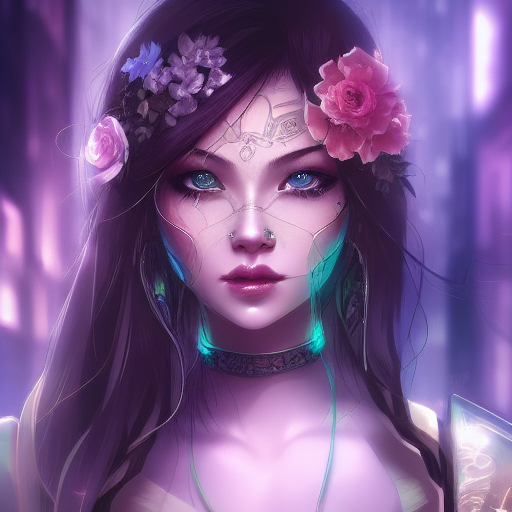

images/outputs/3781389835485629_2023-03-26 17:43:51.png



  0%|          | 0/20 [00:00<?, ?it/s]

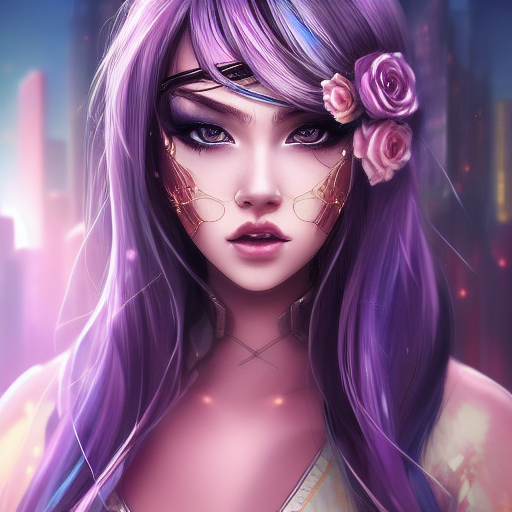

images/outputs/6200273526034484_2023-03-26 17:43:55.png


Seeds for generating images: [3781389835485629, 6200273526034484]



In [5]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from lora_diffusion import tune_lora_scale, patch_pipe

lora_dir = OUTPUT_DIR
model_dir = "runwayml/stable-diffusion-v1-5"
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

lora_dir = lora_dir+"/final_lora.safetensors"

patch_pipe(
    pipe,
    lora_dir,
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder,1.0)

prompt = "art by cypk, portrait of 1girl, pretty detailed face, frontal view, upper body, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)

# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")